# Projeto: Classificador com Rede Neural Artificial - Base de Dados Iris


---

Aluno: Antonio Victor de Oliveira Borssato


## Descrição

Atividade da matéria de Inteligência Computacional do Curso de Mestrado em Informática da Universidade Federal do Espírito Santo.

Objetivo: Desenvolvimento de um classificador baseado em Rede Neural Artificial do tipo feed-forward aplicado à base de dados Iris. O objetivo é treinar e avaliar o modelo utilizando a métrica mais adequada para classificação multiclasse, além de realizar a otimização de hiperparâmetros por meio de um grid search.

## Coleta de dados

In [2]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 107.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

iris = load_iris()

X = iris.data
y = iris.target

#deixando um df:
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y) # stratify para garantir balanceamento de classes nas separações

## Pré-processamento

Avaliando o desbalanceamento de classes

In [4]:
df_iris['species'].value_counts()

,count
species,
0,50
1,50
2,50


Pode-se notar que os dados são perfeitamente balanceados entre as classes.

In [5]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


Apesar de das escalas de grandeza serem parecidas, irei reescalar os dados para ganhar um pouco de melhora na convergência.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Definição da Arquitetura da Rede

Como o problema tem os dados bem balanceados, vou usar uma rede neural mais simples, depois usarei grid search para otimizar

In [7]:
!pip install tensorflow
!pip install scikeras

In [8]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import cross_val_score, StratifiedKFold


Como a entrada tem 4 features, a primeira camada terá 4 neurônios.

Como a classificação é simples, começarei com apenas 1 camada oculta, para observar o comportamento do modelo. Essa camada terá o dobro de neurônios da camada de entrada, ou seja, 2*4 = 8 neurônios. A saída terá 3 neurônios, um para cada espécie de flor.

Os pesos serão inicializados aleatoriamente e a função de ativação será `ReLu` nas camadas ocultas e `softmax` na saída.

A função de custo será `sparse_categorical_crossentropy`, pois segundo o próprio keras, ela é boa para classificação com rótulos inteiros:
> sparse_categorical_crossentropy: Computes the crossentropy loss between the labels and predictions. Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers.

Vou usar o otimizador Adam, pois ele usa taxa de aprendizado para cada parâmetro da rede de forma adaptativa.

Na métrica, vou usar Macro F1-Score, pois relaciona o recall e precision, que são boas métricas para problemas de classificação.

PS: vou criar a funções com valores padrão, para posteriormente poder alterá-los com o grid search.

In [10]:
def create_model(learn_rate=0.001, neurons=4, activation_in = 'relu', num_camadas_ocultas = 1, otimizador='Adam'):
  #o modelo será sequencial
  model = Sequential()

  #camada de entrada
  model.add(Dense(neurons, activation=activation_in, kernel_initializer = 'random_uniform', input_shape=(X_train.shape[1],))) #camada de entrada

  #usando 'for' para ser possível adicionar mais camadas ocultas
  for _ in range(num_camadas_ocultas):
    model.add(Dense(neurons*2, activation=activation_in, kernel_initializer = 'random_uniform')) #camada oculta
  model.add(Dense(3, activation='softmax')) #camada de saída

  #definindo otimizador
  if otimizador == 'Adam':
    otimizador = Adam(learning_rate=learn_rate,  clipvalue = 0.5)
  elif otimizador == 'SGD':
    otimizador = SGD(learning_rate=learn_rate, clipvalue = 0.5)
  elif otimizador == 'RMSprop':
    otimizador = RMSprop(learning_rate=learn_rate, clipvalue = 0.5)
  else:
    otimizador = Adam(learning_rate=learn_rate,  clipvalue = 0.5)

  #compilando com a função de custo, otimizador e métrica
  model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = otimizador,
    metrics = [F1Score(average='macro', name='f1_score')]
  )

  model._estimator_type = "classifier"
  return model

## Treinamento e Avaliação

Começarei com 100 épocas para ver se o modelo converge. Como só há 150 amostras, sendo 75% usadas para treinamento (113), vou usar batches de 20 amostras

In [38]:
#criando a instância do modelo
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=0)

#configurando o cross-validation para ser estratificado, com 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True)

#realizando a cross-validation no conjunto de treino
cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1_macro', n_jobs=-1)

#Resultados
print('\n\nResultados do cross-validation:')
print(f"Cross-validation results: {cv_results}")
print(f"Mean f1_score macro: {np.mean(cv_results)}")
print(f"Standard deviation: {np.std(cv_results)}")



Resultados do cross-validation:
Cross-validation results: [0.81481481 0.81481481 0.79259259 0.95555556 0.85645933]
Mean f1_score macro: 0.8468474215842636
Standard deviation: 0.05814741514371901


Percebe-se que o modelo teve um desempenho entre mediano e bom, considerando os parâmetros estabelecidos. Sabendo que 1 é o valor máximo do f1-score e 0.5 diz respeito a um classificador aleatório, 0.8468 é um resultado satisfatório para um modelo sem otimização de hiperparâmetro. Isso significa que o modelo consegue classificar uma boa parte das flores.

Farei agora o treinamento com todos os dados de treino e avaliação com os dados de teste

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)




F1-score macro no conjunto de testes: 0.9220389805097451



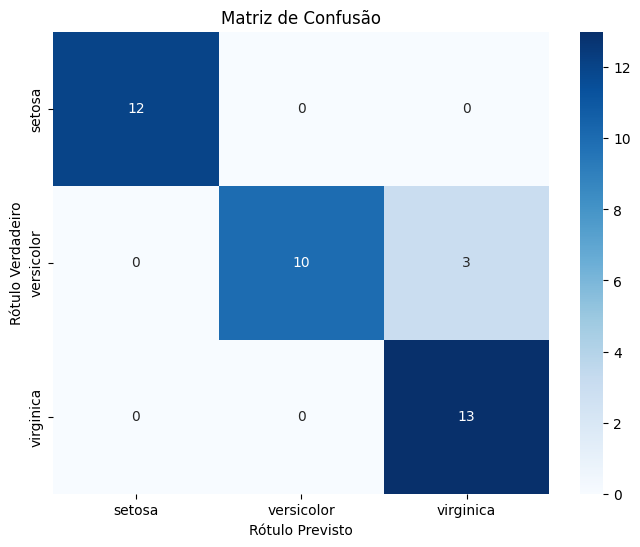

In [39]:
from sklearn.metrics import f1_score

#treinando o modelo no conjunto de treino completo
model.fit(X_train, y_train)

#fazendo previsões no conjunto de teste
y_pred = model.predict(X_test)

#calculando o F1-score macro no conjunto de teste
f1_test = f1_score(y_test, y_pred, average='macro')

#exibindo o F1-score macro no conjunto de teste
print(f"\n\nF1-score macro no conjunto de testes: {f1_test}\n")


#plotando a matriz de confusão
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

Percebe-se que o modelo teve um bom resultado, se confundindo em apenas 3 classificações, das 38. Vejamos, porém, se é possível melhorar o resultado com Grid_serch.

## Otimização com Grid Search

Para encontrar a melhor combinação, farei o grid search com uma gama de possíveis parâmetros, alterando aspectos como a taxa de aprendizado, otimizador, número de neurônios, etc.

Nota: inicialmente tentei executar com mais variabilidade de parâmentros, como funções de ativação de camadas, número de camadas ocultas, etc. Porém, devido ao alto custo computacional e o altíssimo tempo de execução, tive que limitar os parâmetros nesse trabalho.

In [13]:
parametros = {
    'learn_rate': [0.001, 0.01, 0.1]
    ,'neurons': [4, 8]
    ,'otimizador': ['Adam', 'RMSprop']
    ,'epochs': [100, 500]
    ,'batch_size': [20, 50]
}

#isso aqui é para passar no KerasClassifier, senão o gridsearch não consegue alterar dentro do create_model
default_params = {
    'learn_rate': 0.001,
    'neurons': 4,
    'otimizador': 'Adam',
    'epochs': 100,
    'batch_size': 10
}

In [14]:
from sklearn.model_selection import GridSearchCV

#criando o modelo
model_grid_search = KerasClassifier(model=create_model, verbose=2, **default_params)

#criando o grid search
grid_search = GridSearchCV(estimator=model_grid_search, param_grid=parametros, cv=kf, scoring='f1_macro', n_jobs=-1)

#treinando o grid search
resultado_grid = grid_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/500


/usr/local/lib/python3.11/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 - 2s - 330ms/step - f1_score: 0.4107 - loss: 1.0989
Epoch 2/500
6/6 - 0s - 64ms/step - f1_score: 0.3978 - loss: 1.0864
Epoch 3/500
6/6 - 0s - 8ms/step - f1_score: 0.4088 - loss: 1.0433
Epoch 4/500
6/6 - 0s - 8ms/step - f1_score: 0.4132 - loss: 0.9571
Epoch 5/500
6/6 - 0s - 9ms/step - f1_score: 0.4132 - loss: 0.8247
Epoch 6/500
6/6 - 0s - 7ms/step - f1_score: 0.4118 - loss: 0.7121
Epoch 7/500
6/6 - 0s - 7ms/step - f1_score: 0.4045 - loss: 0.6445
Epoch 8/500
6/6 - 0s - 10ms/step - f1_score: 0.4000 - loss: 0.6040
Epoch 9/500
6/6 - 0s - 10ms/step - f1_score: 0.4000 - loss: 0.5740
Epoch 10/500
6/6 - 0s - 8ms/step - f1_score: 0.4000 - loss: 0.5500
Epoch 11/500
6/6 - 0s - 10ms/step - f1_score: 0.4000 - loss: 0.5328
Epoch 12/500
6/6 - 0s - 9ms/step - f1_score: 0.4000 - loss: 0.5187
Epoch 13/500
6/6 - 0s - 8ms/step - f1_score: 0.4000 - loss: 0.5073
Epoch 14/500
6/6 - 0s - 8ms/step - f1_score: 0.4000 - loss: 0.4999
Epoch 15/500
6/6 - 0s - 7ms/step - f1_score: 0.4000 - loss: 0.4922
Epoch 16/5

In [15]:
print(f'Melhor F1-Score: {resultado_grid.best_score_:.4f} usando {resultado_grid.best_params_}.')

Melhor F1-Score: 0.9821 usando {'batch_size': 20, 'epochs': 500, 'learn_rate': 0.01, 'neurons': 4, 'otimizador': 'Adam'}.


Percebe-se que a combinação de hiperparâmetros com grid search obteve um F1-Score superior ao resultado anterior, mostrando que era de fato possível melhorar os resultados do modelo.

Abaixo encontram-se os resultados de cada combinação de hiperparâmetros:

In [16]:
results_df = pd.DataFrame(grid_search.cv_results_)

tabela_resultados = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
print("Tabela de Resultados do Grid Search:")
display(tabela_resultados)

Tabela de Resultados do Grid Search:


,params,mean_test_score,std_test_score,rank_test_score
17,"{'batch_size': 20, 'epochs': 500, 'learn_rate'...",0.982143,0.035714,1
16,"{'batch_size': 20, 'epochs': 500, 'learn_rate'...",0.982143,0.035714,1
6,"{'batch_size': 20, 'epochs': 100, 'learn_rate'...",0.964204,0.033431,3
40,"{'batch_size': 50, 'epochs': 500, 'learn_rate'...",0.963520,0.033635,4
45,"{'batch_size': 50, 'epochs': 500, 'learn_rate'...",0.963439,0.018317,5
30,"{'batch_size': 50, 'epochs': 100, 'learn_rate'...",0.963095,0.045238,6
12,"{'batch_size': 20, 'epochs': 500, 'learn_rate'...",0.963095,0.045238,6
13,"{'batch_size': 20, 'epochs': 500, 'learn_rate'...",0.963095,0.045238,6
39,"{'batch_size': 50, 'epochs': 500, 'learn_rate'...",0.963095,0.045238,6
7,"{'batch_size': 20, 'epochs': 100, 'learn_rate'...",0.962853,0.035400,10


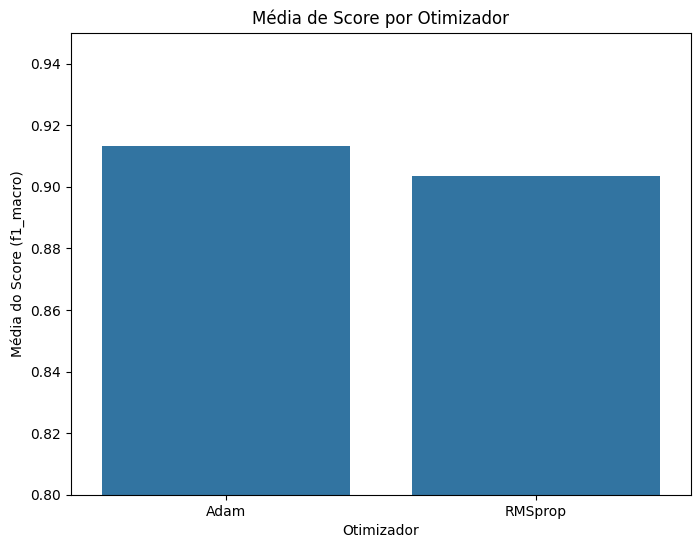

2/2 - 0s - 135ms/step


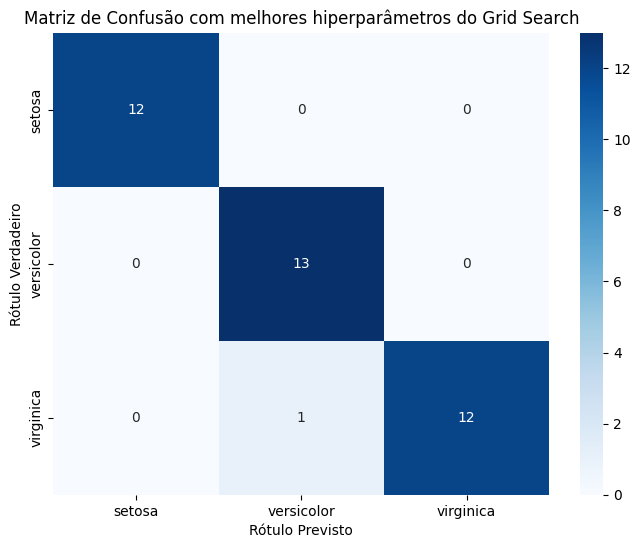

In [36]:
#@title
optimizers_result = results_df[['mean_test_score', 'param_otimizador']]
media_otimizadores = optimizers_result.groupby('param_otimizador')['mean_test_score'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='param_otimizador', y='mean_test_score', data=media_otimizadores)
plt.xlabel("Otimizador")
plt.ylabel("Média do Score (f1_macro)")
plt.ylim(0.8, 0.95)
plt.title("Média de Score por Otimizador")
plt.show()

#matriz de confusão
y_pred_gs = grid_search.predict(X_test)
cm_gs = confusion_matrix(y_pred_gs, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_gs, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão com melhores hiperparâmetros do Grid Search')
plt.show()

Pode-se perceber que os resultos de f1-score do modelo com grid search saíram de algo próximo a uma decisão aleatória no pior caso (0.568262) para chegar a um ótimo classificador (0.982143), após a definição dos melhores hiperparâmetros. Além disso, os resultados da matriz de confusão mostram que o modelo saiu de 4 erros para apenas 1.

É interessante notar que, para os parâmetros numéricos, a melhor combinação não ocorreu com os maiores valores de taxa de aprendizado, neurônicos e tamanho de batch. Entretanto, no caso do número de épocas, o melhor resultado foi encontrado para o maior valor disponível (500).

Em relação aos otimizadores, o Adam mostrou uma média de resultados levemente superior ao RMSProp, indicando que e ele parece mais adequado para os dados desse problema.

## Conclusões

Percebe-se que a otimização por grid search é capaz de alavancar o modelo, entretanto, mesmo sem nenhuma seleção de hiperparâmetros, o algoritmo de rede neural mostra seu potencial e robustez, uma vez que alcançou um F1-score satisfatório logo no primeiro teste. O resultado final foi satisfatório, mostrando que a rede errou em apenas 2,63% das classificações no conjunto de teste.

Nota-se que a métrica escolhida para análise é de fato eficiente para avaliar problemas de classificação, uma vez que a relação entre recall e precisão permite visualizar o quão "equilibrado" está o modelo. Em outras palavras, é possível perceber se o modelo está acertando quando precisa acertar.

Por fim, vale ressaltar que alguns experimentos podem ser feitos para incrementar a resolução desse problema de classificação, com o uso de mais hiperparâmetros no grid search, como o número de camadas, tipos de funções de ativação e, especialmente, um maior número de épocas. Outro teste possível é a mudança da métrica de avaliação do modelo, como a curva ROC e o AUC.